# Welcome to the Modular Multimodal Data Fusion ML Pipeline for stress detection for the WESAD Database

## Table of contents






## Getting Started:
First, download necessary packages, if you are using a venv such as Conda, activate this first.

In [ ]:
%pip install -r requirements.txt

## Data Installation
If you are on Linux, run this cell to download and extract the WESAD dataset automatically, otherwise download manually [here](https://uni-siegen.sciebo.de/s/HGdUkoNlW1Ub0Gx/download) and unzip the `WESAD` file into the `wesad` directory i.e. `wesad/WESAD/`

In [ ]:
%cd src/wesad && bash download_database.sh
%cd ../..

## Data Preprocessing

This will automatically extract the biosensor data from the WESAD directory into several merged files in `.pkl` format.

This will take around 10 minutes depending on the machine.

In [ ]:
from src.wesad.data_preprocessing import WESADDataPreprocessor

preprocessor = WESADDataPreprocessor('src/wesad/WESAD/')
preprocessor.preprocess()

## Signal Preprocessing Steps
We will preprocess each signal with their respective preprocessing steps:

### Chest Signals

#### ECG
- **Smoothing**: Savitzky–Golay filter with window size 11 and order 3.
- **Filtering**: Butterworth band-pass filter of order 3 with cutoff frequencies 0.7 Hz and 3.7 Hz.

#### EMG
- **Smoothing**: Savitzky–Golay filter with window size 11 and order 3.
- **Filtering**: Butterworth lowpass filter of order 3 with cutoff frequency 0.5 Hz.

#### EDA
- **Smoothing**: Savitzky–Golay filter with window size 11 and order 3.
- **Filtering**: Butterworth lowpass filter of order 2 with cutoff frequency 5 Hz.

#### TEMP
- **Smoothing**: Savitzky–Golay filter with window size 11 and order 3.

#### RESP
- **Smoothing**: Savitzky–Golay filter with window size 11 and order 3.
- **Filtering**: Butterworth band-pass filter of order 3 with cutoff frequencies 0.1 Hz and 0.35 Hz.

#### ACC
- **Smoothing**: Savitzky–Golay filter with window size 31 and order 5.

### Wrist Signals

#### BVP
- **Filtering**: Butterworth band-pass filter of order 3 with cutoff frequencies 0.7 Hz and 3.7 Hz.

#### TEMP
- **Smoothing**: Savitzky–Golay filter with window size 11 and order 3.

#### ACC
- **Filtering**: Finite Impulse Response (FIR) filter with a length of 64 with a cut-off frequency of 0.4 Hz.


In [ ]:
# set config_files
CHEST_CONFIG = 'config_files/dataset/wesad_chest_configuration.json'
WRIST_CONFIG = 'config_files/dataset/wesad_wrist_configuration.json'

In [ ]:
from src.ml_pipeline.preprocessing import SignalPreprocessor

# preprocess the chest data
signal_preprocessor = SignalPreprocessor('src/wesad/WESAD/raw/merged_chest.pkl', 'src/wesad/WESAD/cleaned/chest_preprocessed.pkl', CHEST_CONFIG)
signal_preprocessor.preprocess_signals()

# preprocess the wrist data
signal_preprocessor = SignalPreprocessor('src/wesad/WESAD/raw/merged_wrist.pkl', 'src/wesad/WESAD/cleaned/wrist_preprocessed.pkl', WRIST_CONFIG, wrist=True)
signal_preprocessor.preprocess_signals()

## Traditional Machine Learning: Manual Feature Extraction

During the feature extraction, data is loaded in an augmented manner using a 60-second window with a sliding length of 5 seconds.

The manual feature extraction derives the following features:

In [ ]:
from src.ml_pipeline.data_loader import DataAugmenter
from src.ml_pipeline.feature_extraction import ManualFE

WINDOW_LENGTH = 60
SLIDING_LENGTH = 5

CHEST_CONFIG = 'config_files/dataset/wesad_chest_configuration.json'
WRIST_CONFIG = 'config_files/dataset/wesad_wrist_configuration.json'

wrist_augmenter = DataAugmenter('src/wesad/WESAD/cleaned/wrist_preprocessed.pkl', WRIST_CONFIG)
batches = wrist_augmenter.segment_data(WINDOW_LENGTH, SLIDING_LENGTH)

manual_fe = ManualFE(batches, 'src/wesad/WESAD/manual_fe/wrist_manual_fe.hdf5', WRIST_CONFIG)
manual_fe.extract_features()

In [ ]:
from src.ml_pipeline.data_loader import DataAugmenter
from src.ml_pipeline.feature_extraction import ManualFE

CHEST_CONFIG = 'config_files/dataset/wesad_chest_configuration.json'
WRIST_CONFIG = 'config_files/dataset/wesad_wrist_configuration.json'

chest_augmenter = DataAugmenter('src/wesad/WESAD/cleaned/chest_preprocessed.pkl', CHEST_CONFIG)
batches = chest_augmenter.segment_data()

manual_fe = ManualFE(batches, 'src/wesad/WESAD/manual_fe/chest_manual_fe.hdf5', CHEST_CONFIG)
manual_fe.extract_features()

## Traditional Machine Learning: Prepare LOSOCV Datasets

Now, using the preprocessed `.pkl` files we will make it into a dataloader - where LOSOCV (Leave one subject out cross validation). The data augmented samples will be used in the training set but ignored in the test set.

In [ ]:
from src.ml_pipeline.data_loader import LOSOCVDataLoader

dataloader_params = {
    'batch_size': 32,
    'shuffle': True,
    # 'num_workers': 4
}

WRIST_CONFIG = 'config_files/dataset/wesad_wrist_configuration.json'
WRIST_FE = 'src/wesad/WESAD/manual_fe/wrist_manual_fe2.hdf5'

losocv_loader = LOSOCVDataLoader(WRIST_FE, WRIST_CONFIG, **dataloader_params)

# Prepare the datasets
DATASETS_PATH = 'src/wesad/WESAD/datasets/wrist_losocv_datasets.pkl'
datasets = losocv_loader.prepare_datasets(DATASETS_PATH)


## Traditional Machine Learning: Train and Validate Models with LOSOCV

Now we can use the prepared datasets and form dataloaders which will then be used to perform LOSOCV on the models. Using the config file we can set the models that we want to test and their corresponding hyperparameters.

In [1]:
from src.ml_pipeline.data_loader import LOSOCVDataLoader
from src.ml_pipeline.train import TraditionalMLTrainer
from src.utils import save_var

WRIST_CONFIG = 'config_files/dataset/wesad_wrist_configuration.json'
DATASETS_PATH = 'src/wesad/WESAD/datasets/wrist_losocv_datasets.pkl'
WRIST_FE = 'src/wesad/WESAD/manual_fe/wrist_manual_fe2.hdf5'

dataloader_params = {
    'batch_size': 32,
    'shuffle': True,
    # 'num_workers': 4
}

# Load tradtional model config
losocv_loader = LOSOCVDataLoader(WRIST_FE, WRIST_CONFIG, **dataloader_params)
dataloaders = losocv_loader.get_data_loaders(DATASETS_PATH)
TRADTIONAL_ML_CONFIG = 'config_files/model_training/random_forest_tuner.json'

results = []
for i, (subject_id, loaders) in enumerate(dataloaders.items()):
    train_loader = loaders['train']
    val_loader = loaders['val']
    
    print(f'Fold {i}')
    print(f'Train: {len(train_loader.dataset)}')
    print(f'Val: {len(val_loader.dataset)}')
    print()

    # Initialize trainer
    trainer = TraditionalMLTrainer(TRADTIONAL_ML_CONFIG, train_loader, val_loader)

    # trained_models = trainer.tune_hyperparameters()
    trained_models = trainer.train()

    result = trainer.validate(trained_models)
    print(result)
    results.append(result)
    if i == 1:
        break

# save the results to pkl
save_var(results, 'src/wesad/WESAD/results/traditional_models/wrist_results.pkl', )

Fold 0
Train: 6205
Val: 36

Training model: RF_est_50_depth_20_minsplit_2
Training model: RF_est_50_depth_10_minsplit_5
Validating model: RF_est_50_depth_20_minsplit_2
Validating model: RF_est_50_depth_10_minsplit_5
{'RF_est_50_depth_20_minsplit_2': {'accuracy': 0.6944444444444444, 'confusion_matrix': array([[19,  0,  0],
       [ 5,  6,  0],
       [ 6,  0,  0]]), 'precision': 0.6398148148148147, 'recall': 0.6944444444444444, 'f1_score': 0.6249833266639989, 'loss': 0.757590236055966}, 'RF_est_50_depth_10_minsplit_5': {'accuracy': 0.7222222222222222, 'confusion_matrix': array([[19,  0,  0],
       [ 4,  7,  0],
       [ 6,  0,  0]]), 'precision': 0.6513409961685823, 'recall': 0.7222222222222222, 'f1_score': 0.6554783950617283, 'loss': 1.1487670146987312}}
Fold 1
Train: 6199
Val: 36

Training model: RF_est_50_depth_20_minsplit_2
Training model: RF_est_50_depth_10_minsplit_5
Validating model: RF_est_50_depth_20_minsplit_2
Validating model: RF_est_50_depth_10_minsplit_5
{'RF_est_50_depth_

## Traditional Machine Learning: Visualize Results

Variable loaded from src/wesad/WESAD/results/traditional_models/wrist_results.pkl
RF_est_50_depth_20_minsplit_2:
  Accuracy: 0.66667
  Loss: 0.76860
  Precision: 0.71971
  Recall: 0.66667
  F1 Score: 0.62054
RF_est_50_depth_10_minsplit_5:
  Accuracy: 0.62500
  Loss: 0.98616
  Precision: 0.73291
  Recall: 0.62500
  F1 Score: 0.57238


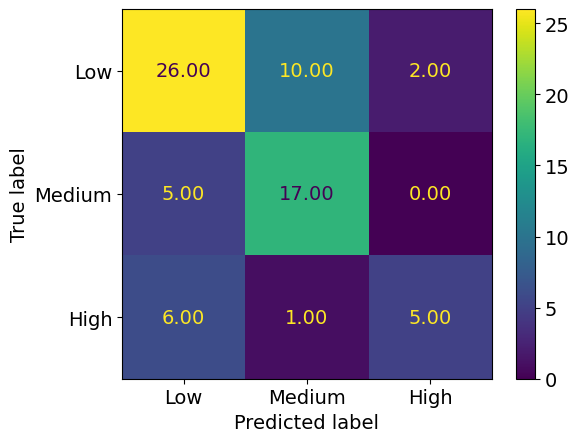

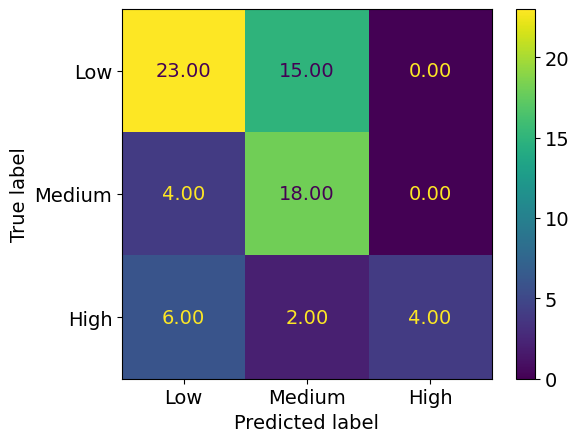

In [2]:
from src.ml_pipeline.analysis import ModelResultsAnalysis
from src.utils import load_var

results = load_var('src/wesad/WESAD/results/traditional_models/wrist_results.pkl')

analysis = ModelResultsAnalysis(results)
analysis.analyze_collective()

## Automatic Feature Extraction

The automatic feature extraction uses autoencoders to derive features from its latent space: